# An Implementation of Bayesian Optimization on hyperparameters tuning of XGBoost

In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from hyperopt import hp
from hyperopt import STATUS_OK
import hyperopt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import xgboost

This is an example of Bayesian Optimization on hyperparameters tuning of XGBoost. The XGBoost model is built as a Digit Recognizer, which is used to classify hand-written digits from 0 to 9.

In [2]:
df = pd.read_csv("train.csv")
df.head()
df.shape

(42000, 785)

In [3]:
X = df.iloc[:,1:]
y = df["label"]

In [4]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [5]:
XGBClassifier()

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [6]:
def objective(params):
#    xgb = xgbo(hyperparameters)
#    scores = cross_val_score(xgb, X_train, y_train,
#                             cv=5,n_jobs = 5, scoring = 'accuracy')
    params['n_jobs'] = 5
    params['objective'] = "multi:softmax"
    params['num_class'] = 10
    dtrain = xgboost.DMatrix(X_train,y_train)
    res = xgboost.cv(params, dtrain, nfold = 3,metrics = "merror", seed = 123)
    mis = (y_train.value_counts()*res["test-merror-mean"]).sum()/len(y_train)
    return(mis)
#objective(example)

Set the space of tuning hyperparameters

In [8]:
space = {
    'booster': hp.choice('booster', ['gbtree','gblinear','dart']),
    'gamma': hp.uniform('gamma', 0.0, 1.0),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.2)),
    'max_depth': hp.choice('max_depth', np.arange(3, 16)),
    'min_child_weight': hp.quniform('min_child_samples', 1, 15, 1),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
    'subsample': hp.uniform('subsample', 0.6, 1.0)
}

In [9]:
#Get an example of parameters dict
from hyperopt.pyll.stochastic import sample
example = sample(space)
example['n_jobs'] = 5
example['objective'] = "multi:softmax"
example['num_class'] = 10
example['max_depth'] = int(example['max_depth'])
example

{'booster': 'dart',
 'colsample_bytree': 0.6217647225862676,
 'gamma': 0.645955343164819,
 'learning_rate': 0.03549193711338195,
 'max_depth': 7,
 'min_child_weight': 7.0,
 'reg_alpha': 0.3426418341735388,
 'reg_lambda': 0.5313409028630852,
 'subsample': 0.9709510781908723,
 'n_jobs': 5,
 'objective': 'multi:softmax',
 'num_class': 10}

In [10]:
from hyperopt import tpe
tpe_alg = tpe.suggest

from hyperopt import Trials
# Trials object to track progress
bayes_trials = Trials()

In [138]:
from hyperopt import fmin

MAX_EVALS = 10

# Optimize
best = fmin(fn = objective, space = space, algo = tpe.suggest, 
            max_evals = MAX_EVALS, trials = bayes_trials)

100%|██████████| 10/10 [4:41:55<00:00, 1723.49s/it, best loss: 0.0948598031292517] 


To get deeper into how BO works over iterations, we run more iterations on a sample from the data.

In [12]:
def objective2(params):
    params['n_jobs'] = 5
    params['objective'] = "multi:softmax"
    params['num_class'] = 10
    dtrain = xgboost.DMatrix(X_train.iloc[:1000,:],y_train[:1000])
    res = xgboost.cv(params, dtrain, nfold = 3,metrics = "merror", seed = 123)
    mis = (y_train.value_counts()*res["test-merror-mean"]).sum()/len(y_train)
    return(mis)

tpe_alg = tpe.suggest

bayes_trials2 = Trials()

MAX_EVALS = 40

best2 = fmin(fn = objective, space = space, algo = tpe.suggest, 
            max_evals = MAX_EVALS, trials = bayes_trials2)

  0%|          | 0/40 [00:00<?, ?it/s, best loss: ?]

/anaconda3/envs/python36env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



100%|██████████| 40/40 [5:13:45<00:00, 730.77s/it, best loss: 0.08294448673469389]   


In [13]:
n_iter = len(bayes_trials2.losses())

After 40 iterations, we got the lowest 3-fold CV misclassification at 0.0829.

# Visualizations on BO

Then let's make some visualizations on result to get deeper into our BO process.

## Chosen Hyperparameters Density

The following are density plots of some model parameters. It is not hard to notice that instead of choosing all the potential candidates with equal chance, BO was actually focusing on some particular areas as BO can choose parameters trials based on the information from the data obatined.

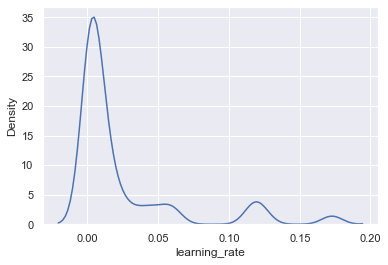

In [22]:
import seaborn as sns; sns.set(color_codes=True)
def params_den(param_name):
    iter_params = bayes_trials2.idxs_vals[1][param_name]
    ax1 = sns.kdeplot(iter_params)
    ax1.set(xlabel = param_name, ylabel = 'Density')
params_den("learning_rate")

In [24]:
bayes_trials2.idxs_vals[1].keys()

dict_keys(['booster', 'colsample_by_tree', 'gamma', 'learning_rate', 'max_depth', 'min_child_samples', 'reg_alpha', 'reg_lambda', 'subsample'])

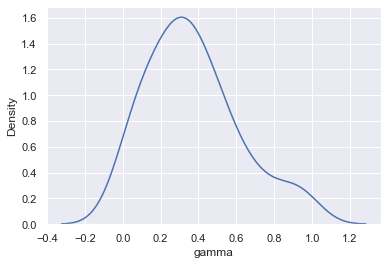

In [32]:
params_den("gamma")

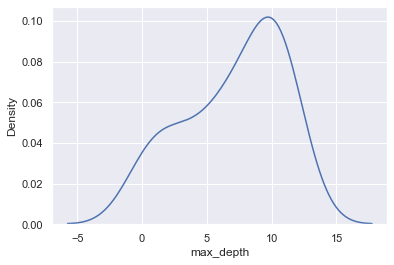

In [30]:
params_den("max_depth")

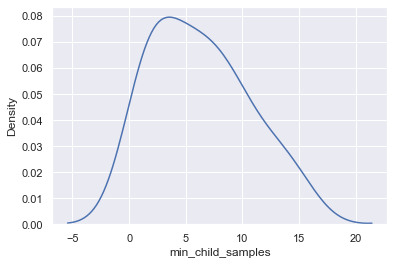

In [37]:
params_den("min_child_samples")

## Values of hyperparameters vs Number of Iterations

We then plot the values of hyperparameters versus number of iterations. Obvious trends are discovered, which demonstrates again that BO is choosing potential hyperparameters using its knowldge of the objective function learned via iterations.

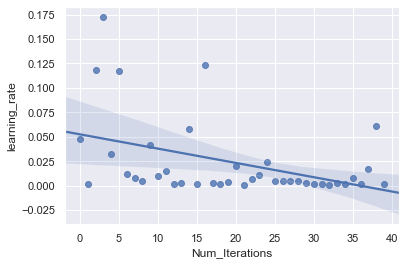

In [40]:
def iter_vs_param(param_name):
    ax2 = sns.regplot(np.array(range(n_iter)),
                      np.array(iter_params(param_name)))
    ax2.set(ylabel = param_name, xlabel = 'Num_Iterations')
iter_vs_param("learning_rate")

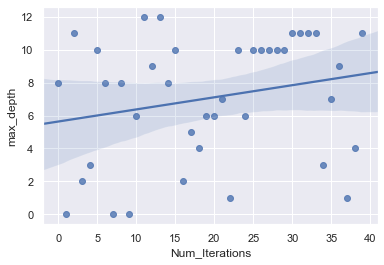

In [41]:
iter_vs_param("max_depth")

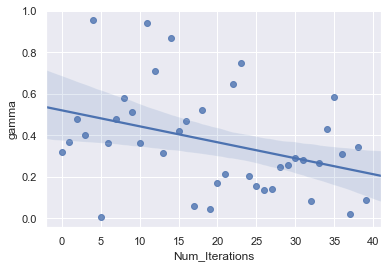

In [42]:
iter_vs_param("gamma")

## Loss vs Number of Iterations

The losses of models also dropped as we did more and more iterations.

[Text(0, 0.5, 'Misclassification Rate'), Text(0.5, 0, 'Num_Iterations')]

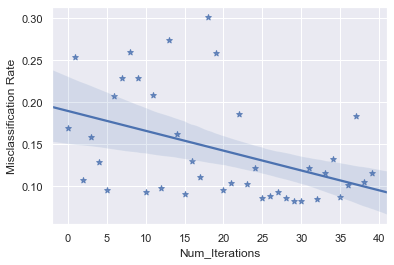

In [43]:
ax3 = sns.regplot(x = np.array(range(n_iter)), y = np.array(bayes_trials2.losses()), marker = "*")
ax3.set(ylabel = 'Misclassification Rate', xlabel = 'Num_Iterations')